In [1]:
from pathlib import Path

import jupyter_black
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import polars as pl
import seaborn as sns
from hydra import compose
from hydra import initialize
from hydra.core.global_hydra import GlobalHydra

from src.utils.metrics import event_detection_ap
from src.utils.post_process import post_process_for_seg

jupyter_black.load()
# plt.style.use("ggplot")
sns.set()

EXP_NAME = "exp075"
RUN_NAME = "single"
RESULT_DIR = Path("../output/train") / EXP_NAME / RUN_NAME


def load_config(result_dir: Path):
    # clear previous initialization
    GlobalHydra.instance().clear()

    # initialize hydra
    config_path = result_dir / ".hydra"
    initialize(config_path=config_path.as_posix())
    # load the config
    cfg = compose(config_name="config")

    return cfg

In [2]:
cfg = load_config(RESULT_DIR)
# cfg.dir.data_dir = (
#     "/home/kuto/kaggle/kaggle-sleep-v2/data/child-mind-institute-detect-sleep-states"
# )
preds = np.load(RESULT_DIR / "preds.npy")
labels = np.load(RESULT_DIR / "labels.npy")
keys = np.load(RESULT_DIR / "keys.npy")

gt_df = pd.read_csv(Path(cfg.dir.data_dir) / "train_events.csv")
gt_df = gt_df[gt_df["series_id"].isin(cfg.split.valid_series_ids)].dropna().reset_index(drop=True)

/tmp/ipykernel_1842873/296831329.py:32: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path=config_path.as_posix())


In [3]:
def min_max_normalize(x):
    return (x - x.min()) / (x.max() - x.min())

In [4]:
# preds[:, :, 0] = min_max_normalize(preds[:, :, 0])
# preds[:, :, 1] = min_max_normalize(preds[:, :, 1])
# preds[:, :, 2] = min_max_normalize(preds[:, :, 2])

In [5]:
preds.shape

(4814, 5760, 3)

In [6]:
def get_series_events(df: pl.DataFrame):
    pred_onset_steps = df.filter(df["pred_class"].diff() > 0)["step"].to_list()
    pred_wakeup_steps = df.filter(df["pred_class"].diff() < 0)["step"].to_list()
    # pred_onset_steps = df.filter(df['pred_class'].diff() > 0)['step'].to_list()
    # pred_wakeup_steps = df.filter(df['pred_class'].diff() < 0)['step'].to_list()
    if len(pred_onset_steps) > 0:
        # Ensuring all predicted sleep periods begin and end
        if min(pred_wakeup_steps) < min(pred_onset_steps):
            pred_wakeup_steps = pred_wakeup_steps[1:]
        if max(pred_onset_steps) > max(pred_wakeup_steps):
            pred_onset_steps = pred_onset_steps[:-1]

    # Keeping sleep periods longer than 30 minutes
    series_id = df["series_id"].unique()[0]
    events = pl.DataFrame(schema={"series_id": int, "step": int, "event": str, "score": float})

    sleep_periods = [
        (onset, wakeup)
        for onset, wakeup in zip(pred_onset_steps, pred_wakeup_steps)
        if (wakeup - onset) >= 0
    ]
    for onset, wakeup in sleep_periods:
        # Scoring using mean probability over period
        score = df.filter((pl.col("step") >= onset) & (pl.col("step") <= wakeup))["pred"].mean()
        wakeup_score = score
        onset_score = score

        # Adding sleep event to dataframe
        events = events.vstack(
            pl.DataFrame().with_columns(
                pl.Series([series_id, series_id]).alias("series_id"),
                pl.Series([onset, wakeup]).alias("step"),
                pl.Series(["onset", "wakeup"]).alias("event"),
                pl.Series([wakeup_score, onset_score]).alias("score"),
            )
        )
    return events


def post_process_for_asleep(
    keys: list[str],
    preds: np.ndarray,
    score_thr: float = 0.05,
) -> pl.DataFrame:
    """make submission dataframe for segmentation task

    Args:
        keys (list[str]): list of keys. key is "{series_id}_{chunk_id}"
        preds (np.ndarray): (num_series * num_chunks, duration, 2)
        score_th (float, optional): threshold for score. Defaults to 0.5.

    Returns:
        pl.DataFrame: submission dataframe
    """
    series_ids = np.array(list(map(lambda x: x.split("_")[0], keys)))
    unique_series_ids = np.unique(series_ids)

    records = []
    for series_id in unique_series_ids:
        series_idx = np.where(series_ids == series_id)[0]
        this_series_preds = preds[series_idx].reshape(-1, 2)

    if len(pred_onset_steps) > 0:
        # Ensuring all predicted sleep periods begin and end
        if min(pred_wakeup_steps) < min(pred_onset_steps):
            pred_wakeup_steps = pred_wakeup_steps[1:]
        if max(pred_onset_steps) > max(pred_wakeup_steps):
            pred_onset_steps = pred_onset_steps[:-1]
    else:
        records.append(
            {
                "series_id": series_id,
                "step": 0,
                "event": "onset",
                "score": 0,
            }
        )

    sub_df = pl.DataFrame(records).sort(by=["series_id", "step"])
    row_ids = pl.Series(name="row_id", values=np.arange(len(sub_df)))
    sub_df = sub_df.with_columns(row_ids).select(["row_id", "series_id", "step", "event", "score"])
    return sub_df

In [7]:
def objective(trial: optuna.Trial):
    score_th = 0.005
    distance = trial.suggest_int("distance", 1, 200)

    pred_df: pl.DataFrame = post_process_for_seg(
        keys, preds[:, :, [1, 2]], score_th=score_th, distance=distance,
    )
    score = event_detection_ap(gt_df, pred_df.to_pandas())

    return score


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print(study.best_params)

In [8]:
def plot_random_sample(keys, preds, labels, num_samples=1, num_chunks=10):
    # get series ids
    series_ids = np.array(list(map(lambda x: x.split("_")[0], keys)))
    unique_series_ids = np.unique(series_ids)

    # get random series
    random_series_ids = np.random.choice(unique_series_ids, num_samples)

    for i, random_series_id in enumerate(random_series_ids):
        # get random series
        series_idx = np.where(series_ids == random_series_id)[0]
        this_series_preds = preds[series_idx].reshape(-1, 3)
        this_series_labels = labels[series_idx].reshape(-1, 3)

        # split series
        this_series_preds = np.split(this_series_preds, num_chunks)
        this_series_labels = np.split(this_series_labels, num_chunks)

        fig, axs = plt.subplots(num_chunks, 1, figsize=(20, 3 * num_chunks))
        if num_chunks == 1:
            axs = [axs]
        for j in range(num_chunks):
            this_series_preds_chunk = this_series_preds[j]
            this_series_labels_chunk = this_series_labels[j]

            # get onset and wakeup idx
            onset_idx = np.nonzero(this_series_labels_chunk[:, 1])[0]
            wakeup_idx = np.nonzero(this_series_labels_chunk[:, 2])[0]

            axs[j].plot(this_series_preds_chunk[:, 0], label="pred_sleep")
            axs[j].plot(this_series_preds_chunk[:, 1], label="pred_onset")
            axs[j].plot(this_series_preds_chunk[:, 2], label="pred_wakeup")
            axs[j].vlines(onset_idx, 0, 1, label="onset", linestyles="dashed", color="C1")
            axs[j].vlines(wakeup_idx, 0, 1, label="wakeup", linestyles="dashed", color="C2")
            axs[j].set_ylim(-0.1, 1.1)
            axs[j].set_title(f"series_id: {random_series_id} chunk_id: {j}")
            axs[j].legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)

    plt.tight_layout()

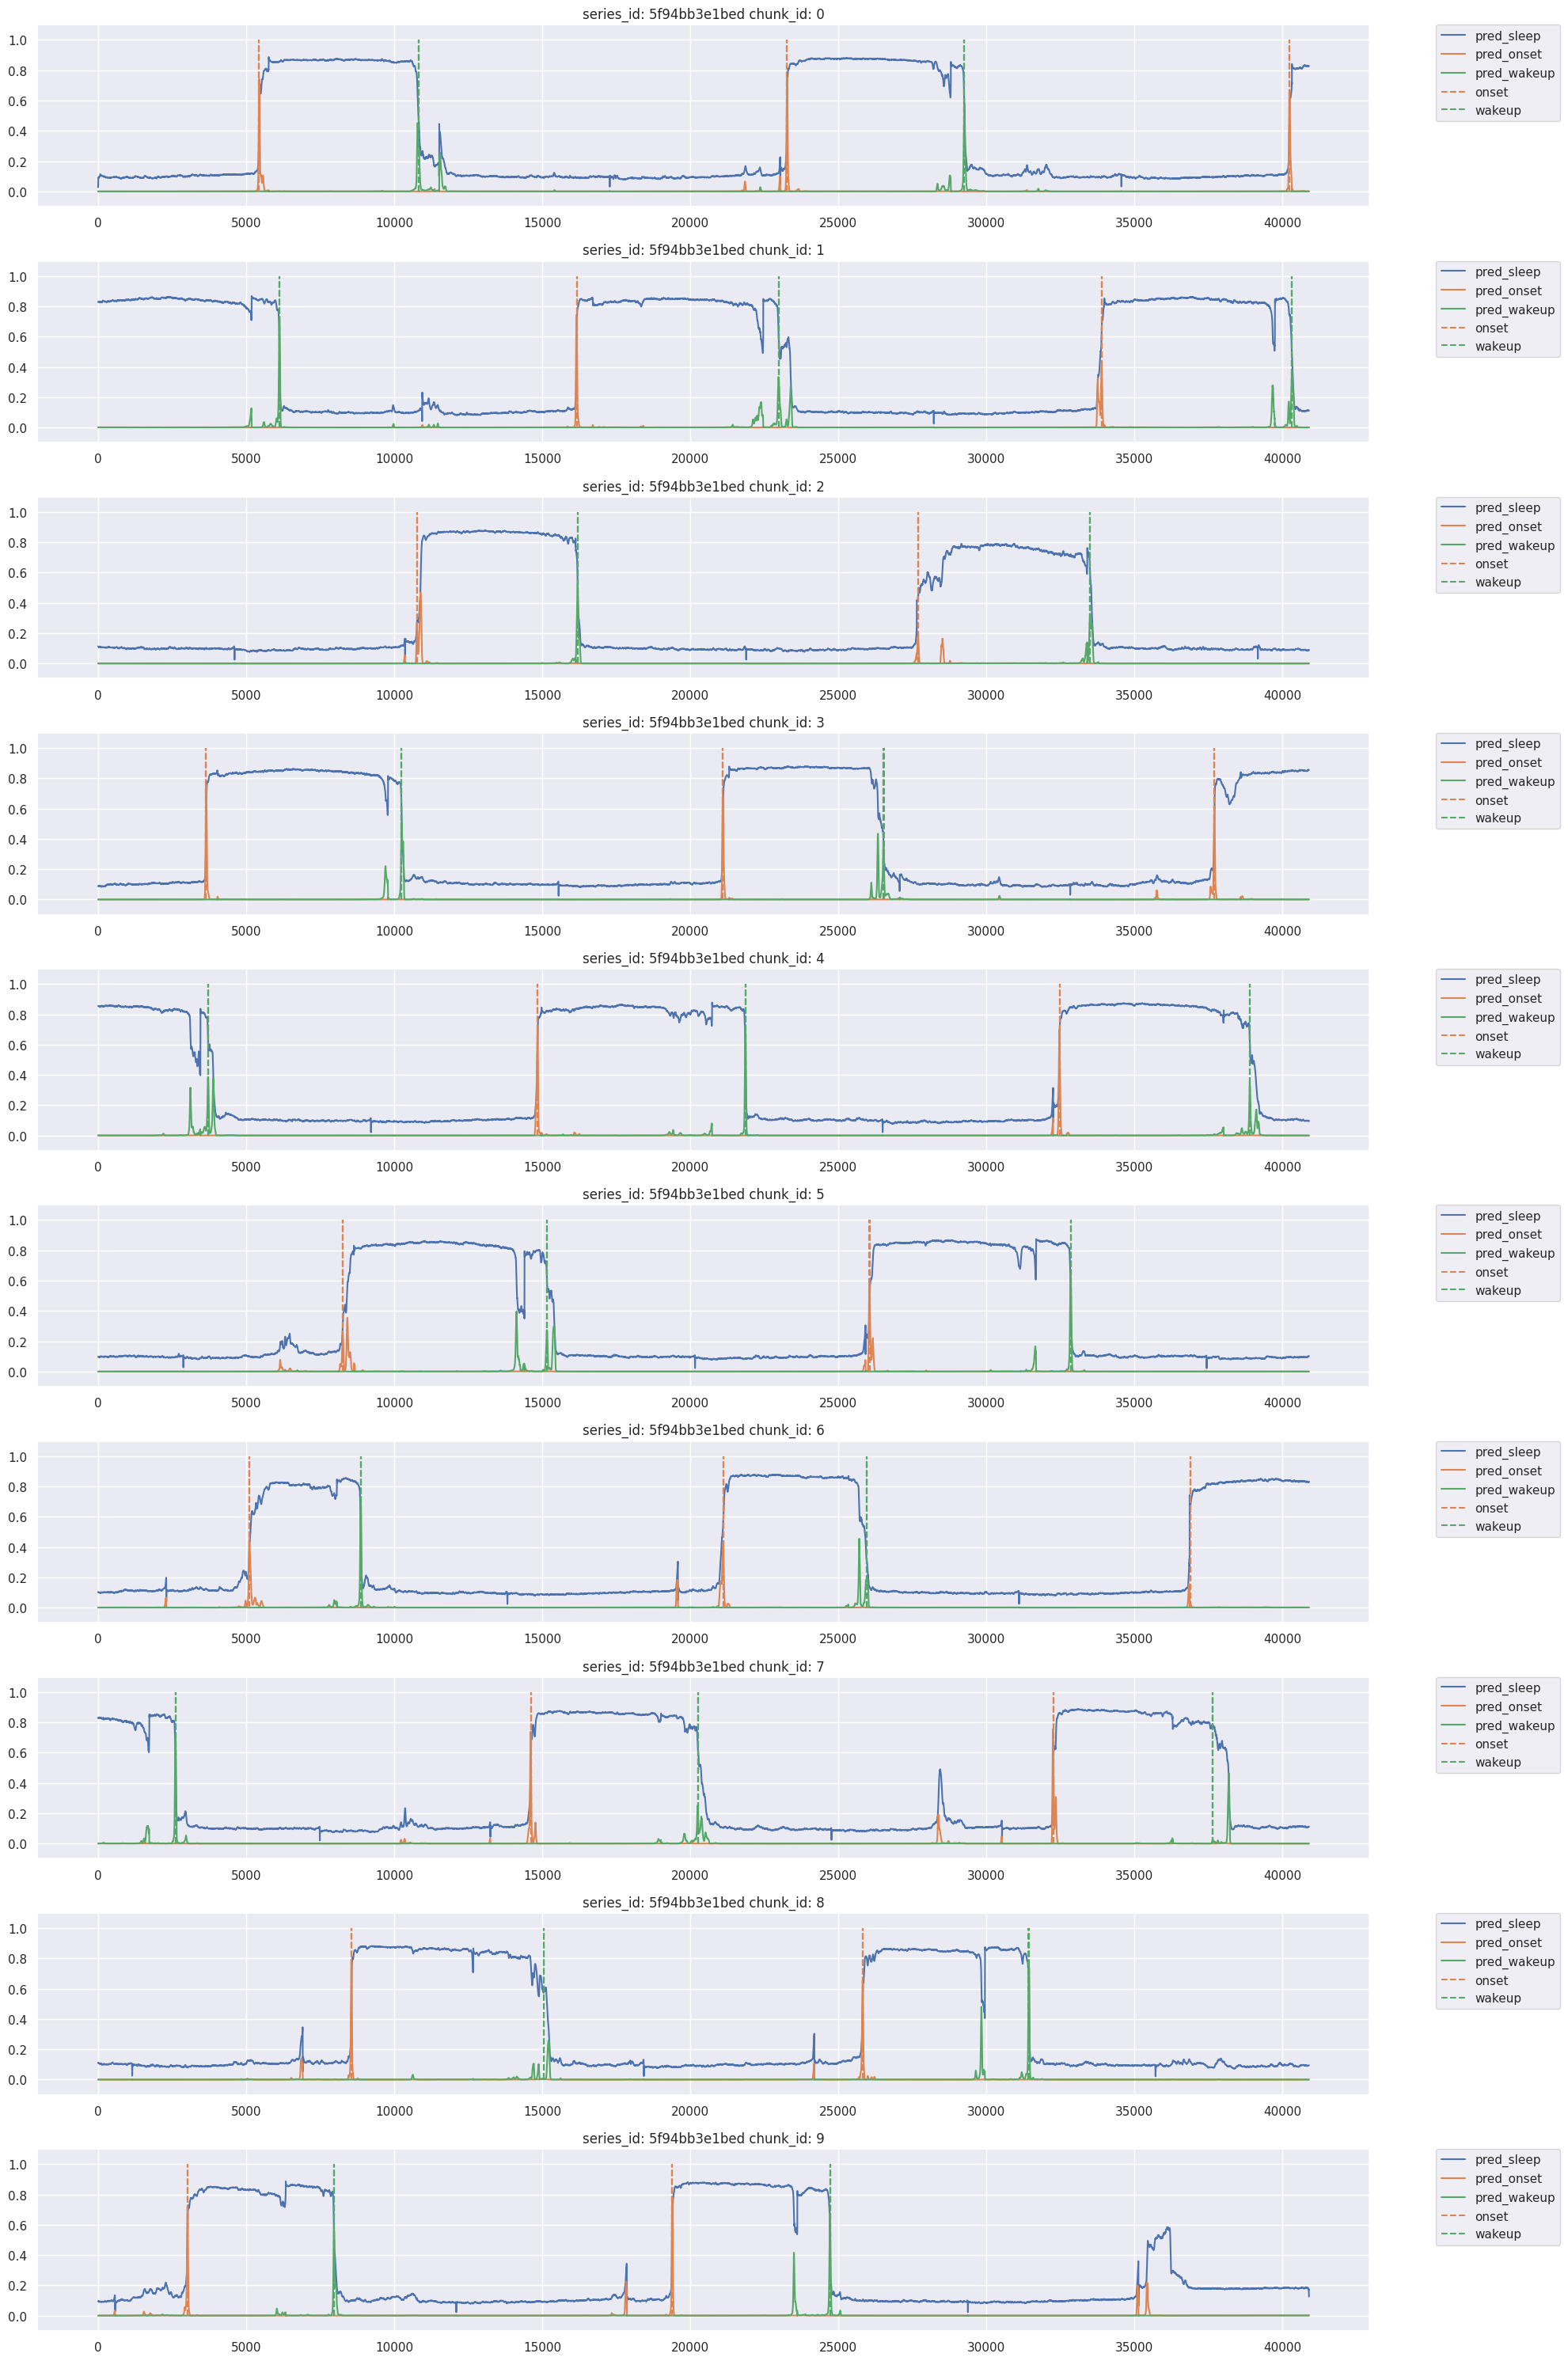

In [9]:
plot_random_sample(keys, preds, labels, num_chunks=10)